In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import KFold

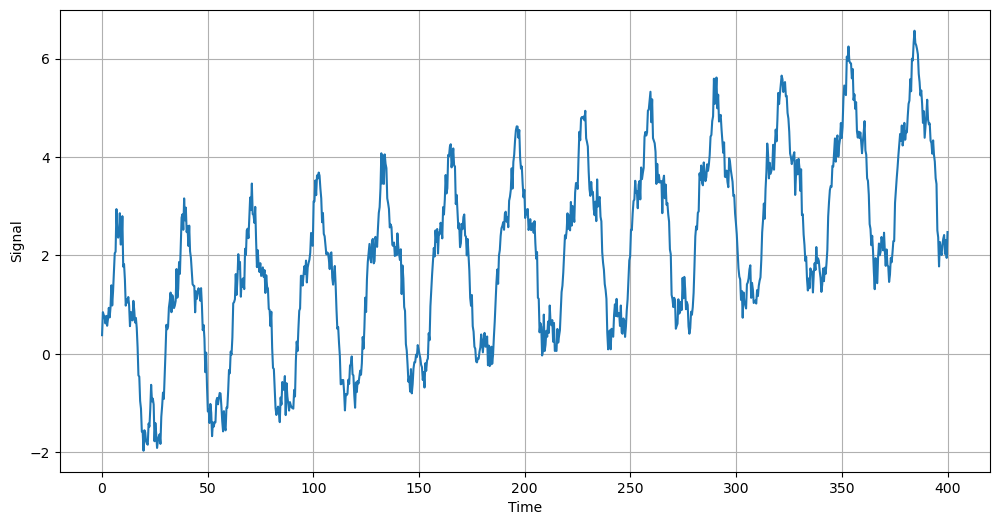

In [81]:

# Generating Time Series Data
def generate_time_series_data(n_steps):
    time = np.linspace(0, 400, n_steps)
    signal = (2 * np.sin(0.2 * time)  # Slow oscillation
              + 0.5 * np.cos(0.8 * time)  # Fast oscillation
              + 0.01 * time  # Linear trend
              + np.random.normal(scale=0.2, size=time.shape))  # Random noise
    return signal, time

data, time = generate_time_series_data(1000)

# Plotting the data for visuals
plt.figure(figsize=(12, 6))
plt.plot(time, data)
plt.ylabel('Signal')
plt.xlabel('Time')
plt.grid()

In [66]:
# Normalizing the Data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# Creating Sliding Window Input-Output Sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 50
X, y = create_sequences(data, window_size)

# Reshape for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define LSTM Model Function
def create_model(lstm_units, hidden_units, learning_rate, activation):
    model = Sequential([
        LSTM(lstm_units, activation=activation, input_shape=(window_size, 1), return_sequences=True),
        LSTM(hidden_units, activation=activation),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Hyperparameter Grid Search
param_grid = {
    'lstm_units': [20, 30, 50],
    'hidden_units': [8, 16],
    'learning_rate': [0.005, 0.01, 0.02],
    'activation': ['relu', 'tanh'],
    'batch_size': [32, 64],
    'epochs': [15, 30]
}

In [67]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = None
best_score = float('inf')
results = []

for lstm_units in param_grid['lstm_units']:  # Iterating through different number of lstm_units
    for hidden_units in param_grid['hidden_units']:  # Iterating through different number of hidden_units
        for learning_rate in param_grid['learning_rate']:  # Iterating through different values for learning rate
            for activation in param_grid['activation']:  # Iterating through different activation functions
                for batch_size in param_grid['batch_size']:  # Iterating through different batch sizes
                    for epochs in param_grid['epochs']:  # Iterating through different number of epochs
                        scores = []

                        for train_index, val_index in kf.split(X):
                            X_train, X_val = X[train_index], X[val_index]
                            y_train, y_val = y[train_index], y[val_index]

                            model = create_model(lstm_units, hidden_units, learning_rate, activation)
                            model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

                            y_pred = model.predict(X_val, verbose=0)
                            score = mean_squared_error(y_val, y_pred)
                            scores.append(score)

                        avg_score = np.mean(scores)
                        results.append({
                            'lstm_units': lstm_units,
                            'hidden_units': hidden_units,
                            'learning_rate': learning_rate,
                            'activation': activation,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'avg_score': avg_score
                        })

                        print(results[-1])  # print current results

                        # Updating the best score
                        if avg_score < best_score:
                            best_score = avg_score
                            best_params = {
                                'lstm_units': lstm_units,
                                'hidden_units': hidden_units,
                                'learning_rate': learning_rate,
                                'activation': activation,
                                'batch_size': batch_size,
                                'epochs': epochs
                            }

results_df = pd.DataFrame(results)  #conver results to a pandas dataframe
results_df.to_csv('Results.csv')
print(f"Best Hyperparameters: {best_params}")
print(f"Best Score: {best_score}")

{'lstm_units': 20, 'hidden_units': 8, 'learning_rate': 0.005, 'activation': 'relu', 'batch_size': 32, 'epochs': 15, 'avg_score': 0.004350430074939859}
{'lstm_units': 20, 'hidden_units': 8, 'learning_rate': 0.005, 'activation': 'relu', 'batch_size': 32, 'epochs': 30, 'avg_score': 0.0017361515482503934}
{'lstm_units': 20, 'hidden_units': 8, 'learning_rate': 0.005, 'activation': 'relu', 'batch_size': 64, 'epochs': 15, 'avg_score': 0.005817307695628457}
{'lstm_units': 20, 'hidden_units': 8, 'learning_rate': 0.005, 'activation': 'relu', 'batch_size': 64, 'epochs': 30, 'avg_score': 0.002419146745464778}
{'lstm_units': 20, 'hidden_units': 8, 'learning_rate': 0.005, 'activation': 'tanh', 'batch_size': 32, 'epochs': 15, 'avg_score': 0.0017989060897986478}
{'lstm_units': 20, 'hidden_units': 8, 'learning_rate': 0.005, 'activation': 'tanh', 'batch_size': 32, 'epochs': 30, 'avg_score': 0.0009065467339668656}
{'lstm_units': 20, 'hidden_units': 8, 'learning_rate': 0.005, 'activation': 'tanh', 'batch_

In [ ]:
# Evaluating Best Model on Test Data
X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):] 

best_model = create_model(
    best_params['lstm_units'],
    best_params['hidden_units'],
    best_params['learning_rate'],
    best_params['activation']
)
best_model.summary()
best_model.fit(X_train, y_train, batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0)

test_predictions = best_model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(y_test_rescaled, test_predictions)
print(f"Test MSE: {mse}")

Model: "sequential_779"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1558 (LSTM)            (None, 50, 30)            3840      
                                                                 
 lstm_1559 (LSTM)            (None, 8)                 1248      
                                                                 
 dense_779 (Dense)           (None, 1)                 9         
                                                                 
Total params: 5,097
Trainable params: 5,097
Non-trainable params: 0
_________________________________________________________________
6/6 [==============================] - 1s 6ms/step
Test MSE: 0.06225148142821089


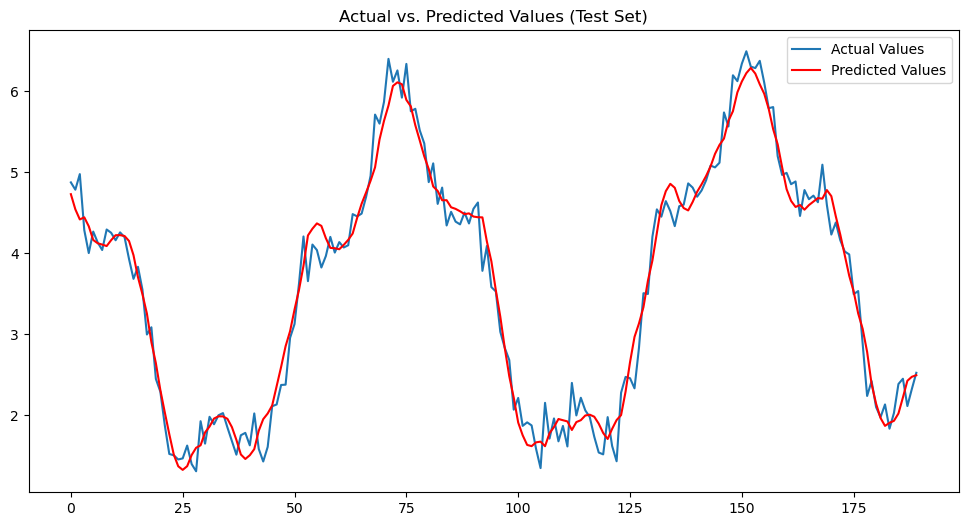

In [74]:
# Visualizing Actual vs. Predicted Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Values')
plt.plot(test_predictions, label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs. Predicted Values (Test Set)')
plt.show()

In [ ]:
# Convert Results to a Grid Format
def create_score_grid(results_df):
    grid = pd.pivot_table(
        results_df,
        values='avg_score',
        index=['learning_rate', 'batch_size', 'epochs', 'activation'],
        columns=['lstm_units', 'hidden_units'],
        aggfunc=np.mean
    )
    return grid

score_grid = create_score_grid(results_df)
score_grid.to_csv("score_grid.csv")

Score Grid:
lstm_units                                        20                  30  \
hidden_units                                      8         16        8    
learning_rate batch_size epochs activation                                 
0.005         32         15     relu        0.004350  0.001929  0.002954   
                                tanh        0.001799  0.001630  0.001660   
                         30     relu        0.001736  0.001546  0.001559   
                                tanh        0.000907  0.001018  0.000870   
              64         15     relu        0.005817  0.003966  0.004222   
                                tanh        0.004107  0.003296  0.003158   
                         30     relu        0.002419  0.002622  0.002211   
                                tanh        0.001233  0.001251  0.000946   
0.010         32         15     relu        0.003205  0.001799  0.002950   
                                tanh        0.001177  0.001327  0.001206   


C:\Users\itsak\AppData\Local\Temp\ipykernel_8020\3034734456.py:3: FutureWarning: The provided callable <function mean at 0x000001DC54E5FA30> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grid = pd.pivot_table(
